<a href="https://colab.research.google.com/github/terryspitz/ipython_notebooks/blob/master/deeperfont_tri_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888
from enum import Enum, IntEnum
import math
import os
import glob
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image, ImageDraw, ImageChops, ImageFont
from IPython.display import display
import tensorflow as tf
print(np.__version__)
print(tf.__version__)
np.set_printoptions(precision=2)
tf.enable_eager_execution()

import matplotlib.pyplot as plt
#!pip install triangle
import triangle as tr

#!pip install fonttools
from fontTools.ttLib import TTFont


1.14.2
1.10.0


ValueError: ignored

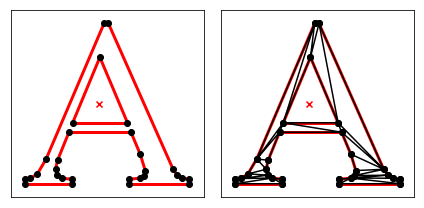

In [5]:
#A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
A = tr.get_data('A')
B = tr.triangulate(A, opts='p')
tr.compare(plt, A, B)
plt.show()

In [0]:
#Read Font outlines from local font files and write outlines to file for fitting

def getCoordinates(font:TTFont, glyphName:str):
    """font, glyphName --> glyph coordinates as expected by "gvar" table
    The result includes four "phantom points" for the glyph metrics,
    as mandated by the "gvar" spec.
    Function from https://github.com/fonttools/fonttools/blob/master/Snippets/interpolate.py
    By inspection coords[0] are all points, and coords[1] are the end of the ranges for each contour (shape)
    """
    glyphTable = font["glyf"]
    glyph = glyphTable.glyphs.get(glyphName)
    if glyph is None:
        return None
    glyph.expand(glyphTable)
    glyph.recalcBounds(glyphTable)
    coords = glyph.getCoordinates(glyphTable)
    start=0
    contours = []
    for end in coords[1]:
        contours.append(coords[0][start:end+1])
        start=end+1
    return contours

class Stroke(IntEnum):
    """
    Enum defining data contents of last dimension
    """
    DX = 0
    DY = 1
    PenDown = 2  # +1 draw stroke, 0 if this stroke is hidden, i.e. to move between contours in the glyph
    EndOfGlyph = 3  # +1 indicates this stroke is the last of the current glyph, else 0
    Size = 4  # size of this enum
    
def generateOutlines(fontfile:str, glyphs:str, max_outline_points:int):
    """
    Read the actual points from all glyphs in the font into numpy array.
    Output is array of glyphs x points x 2 (angle in radians, distance).
    We use float not the original ints from the font - according to https://github.com/fchollet/keras/issues/2218.
    """
    font = TTFont(fontfile)
    unitsPerEm = font['head'].unitsPerEm *0.7
    outlines = np.zeros((max_outline_points, Stroke.Size), np.float32)
    j = 0
    for i, letter in enumerate(glyphs):
        contours = getCoordinates(font, letter)
        startp = (0,0)
        #ttx contours are areas within the glyph, like the outside and inside outlines of an O
        for xy in contours:
            #fill output matrix, start with hidden line to start position
            outlines[j,Stroke.DX] = (xy[0][0]-startp[0])/ unitsPerEm
            outlines[j,Stroke.DY] = (xy[0][1]-startp[1])/ unitsPerEm
            outlines[j,Stroke.PenDown] = 0
            j = j+1
            if j>=max_outline_points: break
            startp = xy[0]
            #then between points
            for n in range(len(xy)-1):
                outlines[j,Stroke.DX] = (xy[n+1][0]-xy[n][0])/ unitsPerEm
                outlines[j,Stroke.DY] = (xy[n+1][1]-xy[n][1])/ unitsPerEm
                outlines[j,Stroke.PenDown] = 1
                j = j+1
                if j>=max_outline_points: break
            #finally wrap last point to first in contour
            outlines[j,Stroke.DX] = (xy[0][0]-xy[-1][0])/ unitsPerEm
            outlines[j,Stroke.DY] = (xy[0][1]-xy[-1][1])/ unitsPerEm
            outlines[j,Stroke.PenDown] = 1
            j = j+1
            if j>=max_outline_points: break
        outlines[j-1,Stroke.EndOfGlyph] = 1  # otherwise leave as 0
    print("Font %s has %d points" % (fontfile, j))
    return outlines
  
def readFonts(files: [str], glyphs: str, max_outline_points:int):
    print('loading {} files'.format(len(files)))
    outlines = []
    for i, fontfile in enumerate(files):
        outlines.append(generateOutlines(fontfile, glyphs, max_outline_points))
    return np.stack(outlines)


In [7]:
print('setup...')
glyphs = [chr(i) for i in range(ord('A'), ord('Z')+1)]
glyphs += [chr(i) for i in range(ord('a'), ord('z')+1)]
glyphs += ['zero','one','two','three','four','five','six','seven','eight','nine']
#glyphs = ['A','B','a','b','one','two']
#glyphs = ['one','two','one','two']
glyphs = ['A'] + glyphs
max_points_per_scanline = 10 # required for g, m
max_outline_points = 5000
ygrid = np.linspace(0.0, 1.0, 30, endpoint=False) #y coordinates to render on
files = glob.glob('deeper/fonts/*.ttf')
outlines = readFonts(files, glyphs, max_outline_points)
testoutlines = tf.constant([[[0.2,0.2,0,0],[0.6,0,1,0],[0,0.6,1,0],[-0.6,0,1,0],[0,-0.6,1,1]]], dtype=tf.float32)
testoutlines = tf.tile(outlines, (1, 10, 1))
testglyphs = ['A'] * 10
print("outline shape (fonts, max_points_per_font, Stroke.Size): ", outlines.shape)
display(drawOutlines(outlines, 30, len(glyphs)))

#test the TF scanline algorithm
for i in range(outlines.shape[0]):
  scanlines = outlinesToScanlines(outlines[i], max_points_per_scanline, ygrid, len(glyphs))
  print("scanlines shape: ", scanlines.shape)
  display(drawScanLines(scanlines, ygrid, 20))

setup...
loading 8 files
Font deeper/fonts\AndikaNewBasic-B.ttf has 2445 points
Font deeper/fonts\AndikaNewBasic-BI.ttf has 2871 points
Font deeper/fonts\AndikaNewBasic-I.ttf has 2876 points
Font deeper/fonts\AndikaNewBasic-R.ttf has 2462 points
Font deeper/fonts\Courier Prime Bold Italic.ttf has 4260 points
Font deeper/fonts\Courier Prime Bold.ttf has 4162 points
Font deeper/fonts\Courier Prime Italic.ttf has 3599 points
Font deeper/fonts\Courier Prime.ttf has 3551 points
outline shape (fonts, max_points_per_font, Stroke.Size):  (8, 5000, 4)


NameError: ignored

In [0]:
os.